**линейный классификатор**

правило Розенблатта  

Евгений Борисов borisov.e@solarl.ru

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_blobs

n_samples = 500
n_clst = 2 # количество классов

X,y = make_blobs( 
        n_samples=n_samples,
        centers=n_clst,  
        cluster_std=[1.0,1.5,]
    )

X.shape, y.shape

((500, 2), (500,))

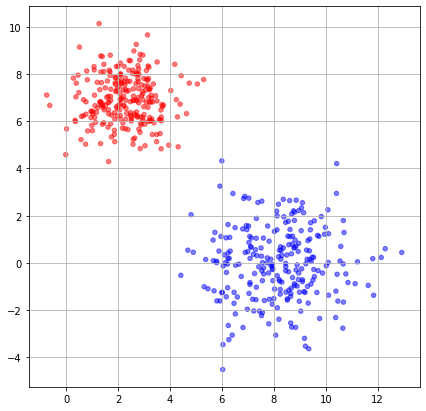

In [3]:
plt.figure(figsize=(7,7))
plt.scatter( x=X[:,0], 
             y=X[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y ], 
             s=20,
             alpha=0.5 )
plt.grid()
plt.show()

---

In [4]:
class Categorizer:
    
    def __init__(self,percentiles=[],scale=None):
        self._percentiles = percentiles if len(percentiles)>0 else [10,25,50,75,95]
        if scale is None:
            self._scale = np.array([])
            self._pos = np.array([])
        else:
            assert type( scale) is np.ndarray, 'scale is not numpy array'
            assert len(scale.shape)==1, 'scale is not 1d numpy array'
            self._scale = scale
            self._pos = np.array([range(len(self._scale))])+1
        
    @property    
    def scale(self): 
        return self._scale
    
    @property    
    def percentiles(self): 
        return self._percentiles
        
    def fit(self,x):
        assert type(x) is np.ndarray, 'x is not numpy array'
        assert len(x.shape)==2,'column vector needed'
        self._scale = np.percentile(x,self._percentiles,axis=0) 
        self._pos = (np.array(range(len(self._scale)))+1)[np.newaxis,:,np.newaxis]
        return self

    def transform(self,x):
        assert len(x.shape)==2,'column vector needed'
        r = ((x[:,np.newaxis,:] > self._scale)*self._pos)
        return np.where( r.sum(axis=1)>0, r.max(axis=1), 0 )

class Binarizer(Categorizer):
    
    def transform(self,x):  
        cat = super().transform(x)
        n_cat=cat.max()+1
        n_fet=x.shape[1]
        return np.eye(n_cat,dtype=np.int8)[cat].reshape(len(x),n_cat*n_fet)

In [5]:
# биннаризация X

In [6]:
X_bin = Binarizer().fit(X).transform(X)
X_bin.shape

(500, 12)

---

In [7]:
# инициализация параметров
W = np.random.normal(loc=0.0, scale=0.1, size=X_bin.shape[1])
W 

array([-0.06886879,  0.08344116,  0.06843483, -0.04613196, -0.048723  ,
       -0.09651451,  0.1963895 , -0.05151477,  0.05286199,  0.07259481,
        0.09910838,  0.07335221])

In [11]:
from sklearn.metrics import accuracy_score
# accuracy_score(y_true, y_pred)

In [8]:
def loss_function(s,y): 
    l = -s*y
    return np.where(l>0,l,0.)

In [9]:
def score(x,w): return x.dot(w)
def predict(x,w): return (score(x,w)>0.).astype(int)

In [12]:
lr = .1 # скорость обучения
fr = .5 # темп "забывания"
acc_threshold=.98 # минимально допустимая погрешность для остановки обучения
n_epoch = 10

acc_history = [] # история изменения погрешности
loss_history = [] # история изменения погрешности

In [13]:
s = score(X_bin,W)
loss = loss_function(s,y).sum()/len(y)
loss_history.append(loss)
loss_history[-1]

0.01637574017921105

In [14]:
acc = accuracy_score( predict(X_bin,W),y )
acc_history.append( acc )
acc_history[-1]

0.328

In [15]:
# метод стохастического градиентного спуска (SGD)
stop=False
for i in range(n_epoch):
    if stop: break
    for j in np.random.permutation(len(y)):
        
        if acc_history[-1] > acc_threshold: # проверяем достижение порога
            print( 'acc bound on epoch %i step %i: %f'%(i,j,acc_history[-1]) )
            stop=True
            break

        xj,yj = X_bin[j,:],y[j]
        
        o = predict(xj,W) # выход
        g = xj.T.dot(o-y[j]) # градиент потери
        W = W - lr * g # коррекция весов
        
        # значение ф-ции потери
        s = score(xj,W)
        loss_j = loss_function(s,yj)
        loss = fr*loss_j +(1-fr)*loss
        loss_history.append(loss)
        
        # считаем погрешность 
        acc_history.append( accuracy_score( predict(X_bin,W),y ) )
        

acc bound on epoch 0 step 142: 0.994000


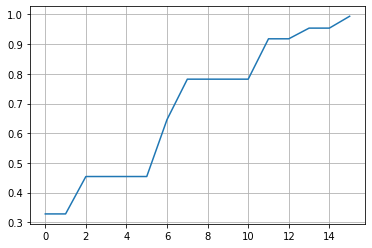

In [17]:
# история изменения погрешности
plt.plot(acc_history)
plt.grid()
plt.show()

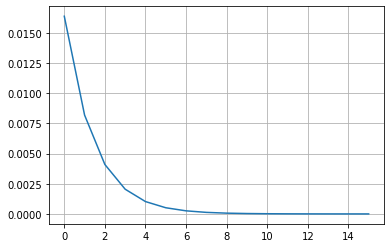

In [18]:
# история изменения погрешности
plt.plot(loss_history)
plt.grid()
plt.show()

---

In [19]:
o = predict(X_bin,W) # выход

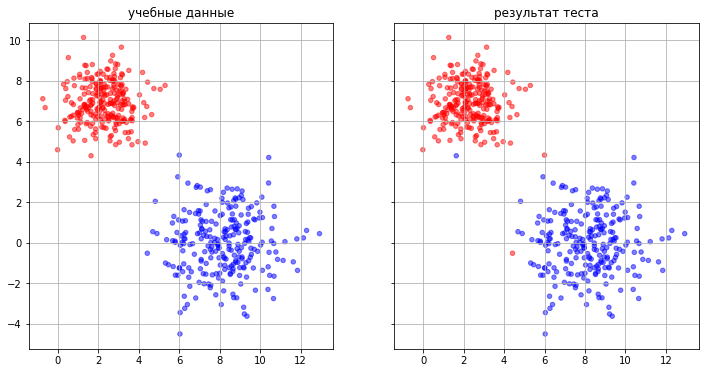

In [20]:
f, axarr = plt.subplots(1,2, sharex=True, sharey=True,figsize=(12,6),)
    
axarr[0].set_title('учебные данные')
axarr[0].scatter( x=X[:,0], 
             y=X[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y ], 
             s=20,
             alpha=0.5 )
axarr[0].grid()

axarr[1].set_title('результат теста')
axarr[1].scatter( x=X[:,0], 
             y=X[:,1], 
             c=[ 'b' if(j>0.5) else 'r' for j in o ], 
             s=20,
             alpha=0.5 )
axarr[1].grid()

plt.show()
